# 01_summary_statistics.ipynb

In [32]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd
import xyzservices.providers as xyz

# Store paths.
INPUT_DATA_UNRESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/unrestricted.csv"
INPUT_DATA_RESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/tables"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)

# Drop rows where voluntary dismissal occurred. 
unrestricted_df = unrestricted_df.loc[unrestricted_df['voluntary_dismissal'] == 0, :]

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

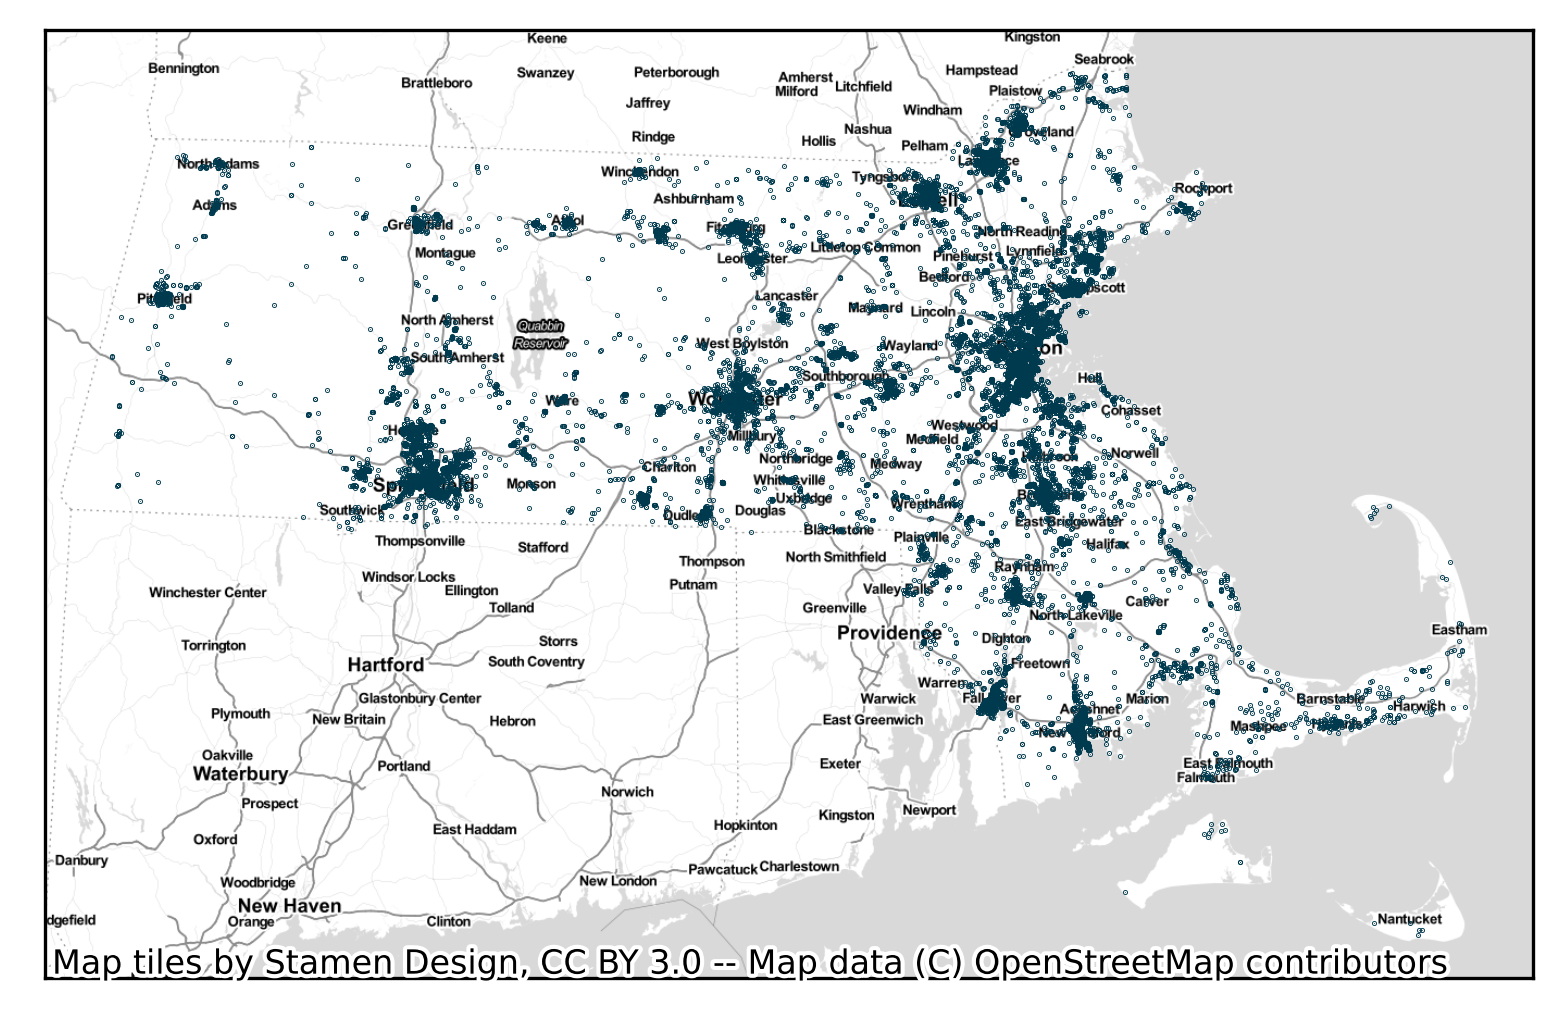

In [37]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots()
ax.set_yticklabels([]) 
ax.set_yticks([])
ax.set_xticklabels([]) 
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax, color=figure_and_table_constants.Colors.P3, markersize=0.05)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evic.png"))

In [3]:
# Master summary statistics function.
def produce_summary_statistics(df: pd.DataFrame):
    # Panel A: Case Initiaton
    panel_A_columns = ['for_cause', 'foreclosure', 'no_cause', 'non_payment', 'for_cause_transfer', 'foreclosure_transfer',
                       'non_payment_transfer', 'no_cause_transfer']
    origin_columns = ['initiating_action', 'initiating_action', 'initiating_action','initiating_action', 
                      'initiating_action', 'initiating_action', 'initiating_action', 'initiating_action']
    target_values = ["SP Summons and Complaint - Cause",  "SP Summons and Complaint - Foreclosure",
                     "SP Summons and Complaint - No Cause", "SP Summons and Complaint - Non-payment of Rent",
                     "SP Transfer - Cause", "SP Transfer - Foreclosure", "SP Transfer - Non-payment of Rent",
                     "SP Transfer- No Cause"]

    for dummy_column, origin_column, target_value in zip(panel_A_columns, origin_columns, target_values):
        df.loc[:, dummy_column] = np.where(df[origin_column] == target_value, 1, 0)

    panel_A = df[sorted(panel_A_columns)].describe().T
    panel_A = pd.concat([panel_A], keys=["Panel A: Case Initiation"])

    # Panel B: Case Resolution
    panel_B_columns = ['mediated', 'dismissed', 'voluntary_dismissal', 'defaulted', 'heard']
    origin_columns = ['disposition_found', 'disposition_found', 'voluntary_dismissal', 'disposition_found',
                      'disposition_found']
    target_values = ["Mediated", "Dismissed", 1, "Defaulted", "Heard"]

    for dummy_column, origin_column, target_value in zip(panel_B_columns, origin_columns, target_values):
        df.loc[:, dummy_column] = np.where(df[origin_column] == target_value, 1, 0)

    panel_B = df[sorted(panel_B_columns)].describe().T
    panel_B = pd.concat([panel_B], keys=["Panel B: Case Resolution"])

    # Panel C: Defendant and Plaintiff Characteristics
    panel_C_columns = ['hasAttyD', 'isEntityD', 'hasAttyP', 'isEntityP', 'judgment']
    panel_C = df[sorted(panel_C_columns)].describe().T
    panel_C = pd.concat([panel_C], keys=["Panel C: Defendant and Plaintiff Characteristics"])

    # Panel D: Tax Assessment Records From F.Y. Following Eviction Filing
    panel_D_columns = ['TOTAL_VAL', 'BLDG_VAL', 'LAND_VAL', 'OTHER_VAL', 'UNITS']
    panel_D = df[sorted(panel_D_columns)].describe().T
    panel_D = pd.concat([panel_D], keys=["Panel C: Assessor Records From Post-Filing F.Y."])

    # Panel E: Zestimates Around Treatment Time
    # Get month of latest docket date for each row and use to grab Zestimates at different times prior to treatment.
    df.loc[:, 'latest_docket_date'] = pd.to_datetime(df['latest_docket_date'])
    df.loc[:, 'nan'] = np.nan
    panel_E_columns = []
    for i in range(-5, 4):
        # This column contains the year-month which is i years relative to treatment for each property.
        offset_docket_month = (df['latest_docket_date'] + pd.tseries.offsets.DateOffset(years=i)).dt.strftime('%Y-%m').copy()

        # Some of the year-months will be outside of the range of our data.
        # For instance, we do not have Zestimates 2 years post-treatment for evictions which occurred in 2022. 
        # For these observations, the offset docket month needs to map to the column of nans we created earlier.
        offset_docket_month.loc[~offset_docket_month.isin(df.columns)] = 'nan'

        # Set column accordingly. 
        idx, cols = pd.factorize(offset_docket_month)
        new_col_name = f'zestimate_{i}_years_relative_to_treatment'
        panel_E_columns.append(new_col_name)
        df.loc[:, new_col_name] = df.reindex(cols, axis=1).to_numpy()[np.arange(len(df)), idx]

    panel_E = df[panel_E_columns].describe().T
    panel_E = pd.concat([panel_E], keys=["Panel E: Zestimates Around Treatment"])


    # Concatenate Panels A-E
    summary_statistics = pd.concat([panel_A, panel_B, panel_C, panel_D, panel_E], axis=0)[['mean', 'std', 'count']]

    return summary_statistics

In [4]:
# Produce summary statistics for unrestricted sample.
summary_statistics_unrestricted = produce_summary_statistics(unrestricted_df)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
display_names = ["For cause", "For cause (transfer)",
                "Foreclosure", "Foreclosure (transfer)",
                 "No cause", "No cause (transfer)",
                 "Non-payment of rent", "Non-payment of rent (transfer)",
                 "Case defaulted", "Case involuntarily dismissed", "Case heard", "Case mediated",
                 "Case voluntarily dismissed", "Defendant has an attorney", "Plaintiff has an attorney",
                "Defendant is an entity", "Plaintiff is an entity", "Money judgment", "Total property value",
                "Building value", "Land value", "Other value", "Units",
                "Five years before latest docket date", "Four years before latest docket date",
                 "Three years before latest docket date", "Two years before latest docket date", 
                "One year before latest docket date", "Latest docket date", "One year after latest docket date",
                "Two years after latest docket date", "Three years after latest docket date"] 
variable_display_names_dict = {key: value for key, value in zip(variable_names, display_names)}

summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)


# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N"}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(thousands=",",
                 formatter={'Mean': "{:.2f}",
                            'S.D.': "{:.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)

In [5]:
# Load restricted data.
restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)
# Drop rows where voluntary dismissal occurred. 
restricted_df = restricted_df.loc[restricted_df['voluntary_dismissal'] == 0, :]

# Separate into treatment and control groups.
restricted_df_treatment = restricted_df.loc[restricted_df['judgment_for_plaintiff'] == 1, :].copy()
restricted_df_control = restricted_df.loc[restricted_df['judgment_for_plaintiff'] == 0, :].copy()

# Produce summary statistics for treatment group.
summary_statistics_treatment = produce_summary_statistics(restricted_df_treatment).drop(columns='std')
summary_statistics_treatment = pd.concat({"Cases Won by Plaintiff": summary_statistics_treatment}, axis=1, names=["", ""])

# Produce summary statistics for control group. 
summary_statistics_control = produce_summary_statistics(restricted_df_control).drop(columns='std')
summary_statistics_control = pd.concat({"Cases Won by Defendant": summary_statistics_control}, axis=1, names=["", ""])

# Combine tables.
summary_statistics_restricted = pd.concat([summary_statistics_control, summary_statistics_treatment], axis=1)

# Rename rows.
summary_statistics_restricted = summary_statistics_restricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_restricted.index = summary_statistics_restricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N"}
summary_statistics_restricted = summary_statistics_restricted.rename(columns=column_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "balance_table.tex")
latex = (summary_statistics_restricted
 .style
 .format(thousands=",", formatter={('Cases Won by Defendant', 'Mean'): "{:.2f}",

                                                      ('Cases Won by Defendant', 'N'): "{:.0f}",
                                                      ('Cases Won by Plaintiff', 'Mean'): "{:.2f}",

                                                      ('Cases Won by Plaintiff', 'N'): "{:.0f}" })
 .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
 .to_latex(None,
           column_format="llcccc",
           hrules=True,
           clines="skip-last;data",
           multicol_align="c")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)